In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *
import pandas as pd

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
cf3 = pd.read_csv("../calibrators/cf3.csv", sep='|')

for col in cf3.columns:
    newcol = col.strip()
    cf3.rename(columns={col:newcol}, inplace=True)

cf3.set_index('PGC', inplace=True)
cf3.head()

/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (5,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Dist,Nd,DM,eDM,C,T,L,M,S,N,...,Vcgp,Vmgp,Vrms,bwMass12,L_Mass12,LDC,HDC,2M++,MKgp,Icnt
PGC,,,,,,,,,,,,,,,,,,,,,
4,50.58,1,33.52,0.4,NaN,NaN,NaN,NaN,NaN,NaN,...,4005,4048,25.0,0.0,9.747,0,0,0,0,0
27,150.66,1,35.89,0.5,NaN,NaN,NaN,NaN,NaN,NaN,...,10959,11275,NaN,0.0,0.000,0,0,0,0,0
40,116.95,1,35.34,0.5,NaN,NaN,NaN,NaN,NaN,NaN,...,6919,7045,0.0,0.0,3.960,0,0,0,0,0
51,240.99,1,36.91,0.5,NaN,NaN,NaN,NaN,NaN,NaN,...,14743,15315,132.0,0.0,253.333,0,0,0,0,0
55,73.79,1,34.34,0.4,NaN,NaN,NaN,NaN,NaN,NaN,...,4454,4507,NaN,0.0,0.000,0,0,0,0,0


In [4]:
cf4 = pd.read_csv("../calibrators/DMs_EDD.csv.test", sep='|')


for col in cf4.columns:
    newcol = col.strip()
    cf4.rename(columns={col:newcol}, inplace=True)

cf4.set_index('pgc', inplace=True)
cf4.head()

,Vh,Vls,V3k,Vmod,f_cosmology,logWimx,logWimx_e,inc,Sqlt,Wqlt,...,pgc1,Nest,Vmodg,Nkt,N15,sglg,sgbg,RS,P0,DM_src
pgc,,,,,,,,,,,,,,,,,,,,,
2,5004,5296,4726,4786,1.013,2.744,0.029,52,0,5,...,73150,200275,4976,0,7,341.4922,20.7395,2,2.02,2
4,4458,4706,4109,4154,1.011,2.189,0.014,85,5,4,...,120,202766,4154,0,0,316.0587,18.4514,2,-2.75,1
12,6548,6685,6195,6297,1.016,2.606,0.021,82,0,5,...,12,210177,6279,0,1,286.4249,11.3510,2,0.56,2
16,5667,5809,5312,5387,1.014,2.515,0.025,65,5,5,...,16,211419,5434,0,1,287.6120,11.7030,2,0.92,1
55,4779,5052,4454,4507,1.012,2.260,0.025,80,5,4,...,55,0,4507,0,0,327.0996,19.7763,2,-2.83,1


In [5]:
def makeTF(logW, band):
    
    if band=='r':
        Sh=-7.37 ; Zh=-20.60
        Sl=-10.32; Zl=-20.86
        logW0=2.41
    elif band=='i':
        Sh=-7.60 ; Zh=-20.85
        Sl=-10.75; Zl=-21.08
        logW0=2.41        
    elif band=='z':
        Sh=-7.61 ; Zh=-20.96
        Sl=-10.78; Zl=-21.15
        logW0=2.44        
    
    Mh = Sh * (logW-2.5) + Zh
    Ml = Sl * (logW-2.5) + Zl
    M = np.asarray([Ml[i] if logW[i]<=logW0 else Mh[i] for i in range(len(logW))])
    
    return M


def MakeHUB(V, DM):
    
    logD = (DM-25)/5.
    logH = np.log10(V) - logD
    H0 = 10**logH
    
    return H0, logH

In [6]:
cf4["DMi_new"] = cf4['iii'].values - makeTF(cf4.logWimx.values, 'i')

cf4[["DMi", "DMi_new"]].head(7)

,DMi,DMi_new
pgc,,
2,0.00,22.70440
4,32.96,32.85675
12,0.00,21.65560
16,34.74,34.54400
55,33.89,33.72000
68,35.03,34.41750
70,35.18,35.12360


In [7]:
# df = cf3[["DM"]].join(cf4[["Vmod", "DMi", "DMi_new","Sqlt", "iii", "logWimx"]][cf4.Sqlt>2], how='left').dropna()

df = cf4[(cf4.Sqlt>2)&(cf4.Vmod>4000)]

df["H0_new"], df["logH_new"] = MakeHUB(df.Vmod, df.DMi_new)
df["H0"], df["logH"] = MakeHUB(df.Vmod, df.DMi)
# df["H0_3"], df["logH_3"] = MakeHUB(df.Vmod, df.DM)

df.head()

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Vh,Vls,V3k,Vmod,f_cosmology,logWimx,logWimx_e,inc,Sqlt,Wqlt,...,sglg,sgbg,RS,P0,DM_src,DMi_new,H0_new,logH_new,H0,logH
pgc,,,,,,,,,,,,,,,,,,,,,
4,4458,4706,4109,4154,1.011,2.189,0.014,85,5,4,...,316.0587,18.4514,2,-2.75,1,32.85675,111.459346,2.047116,106.283658,2.026466
16,5667,5809,5312,5387,1.014,2.515,0.025,65,5,5,...,287.6120,11.7030,2,0.92,1,34.54400,66.457955,1.822547,60.722127,1.783347
55,4779,5052,4454,4507,1.012,2.260,0.025,80,5,4,...,327.0996,19.7763,2,-2.83,1,33.72000,81.262010,1.909888,75.142832,1.875888
68,7664,7740,7338,7480,1.019,2.390,0.043,57,5,5,...,274.3903,7.1770,2,-0.35,1,34.41750,97.814130,1.990402,73.773706,1.867902
70,6800,7040,6447,6557,1.017,2.636,0.005,90,5,5,...,313.2488,17.7663,2,-0.74,1,35.12360,61.941994,1.791985,60.353878,1.780705


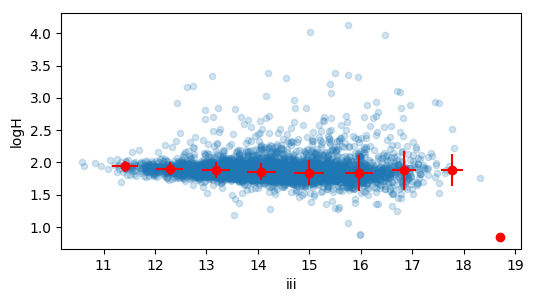

In [8]:
fig = py.figure(figsize=(5, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(3,1) ; p=0

ax = plt.subplot(gs[p]) ; p+=1

df.plot.scatter(x='iii', y='logH', alpha=0.2, ax=ax)

X = df['iii'].values
Y = df['logH'].values
xmin = np.min(X)
xmax = np.max(X)
for i in np.arange(xmin, xmax, 1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and not np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6) 

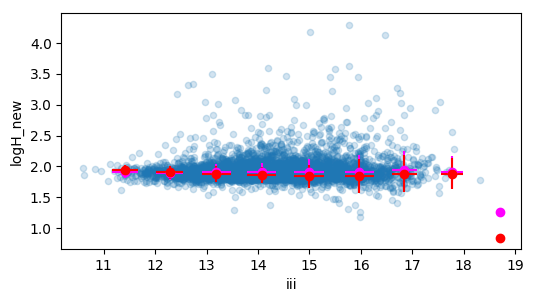

In [9]:
fig = py.figure(figsize=(5, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(3,1) ; p=0

ax = plt.subplot(gs[p]) ; p+=1

df.plot.scatter(x='iii', y='logH_new', alpha=0.2, ax=ax)

X = df['iii'].values
Y = df['logH_new'].values
xmin = np.min(X)
xmax = np.max(X)
for i in np.arange(xmin, xmax, 1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and not np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='magenta', ms=6) 
        
        
X = df['iii'].values
Y = df['logH'].values
xmin = np.min(X)
xmax = np.max(X)
for i in np.arange(xmin, xmax, 1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and not np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6) 

In [10]:
from scipy.optimize import curve_fit


def myHubble(D, H0):
    return H0    

def PlotMe(ax, df, low, high, color='r', delta=0, label=None, param='DM', quality='Sqlt', mag='i'):
    
    dff = df[(df[param]>low) & (df[param]<high) & (df.Vmod > 0) & (df[quality]>2)]
    dff.plot.scatter(
                     x="iii", y='H0_new', alpha=0.1, ax=ax, color='k', s=2
                     )

    X = dff["iii"].values
    Y = dff['H0'].values+delta
    xmin = np.min(X)
    xmax = np.max(X)
    lab = True
    for i in np.arange(xmin, xmax, 1):
        xp = []
        yp = []
        for ii in range(len(X)):
            xi = X[ii]
            if xi>=i and xi<i+1 and not np.isnan(Y[ii]):
                xp.append(xi)
                yp.append(Y[ii])
        if len(xp)>0:
            if lab:
                labe = label
                lab = False
            else:
                labe=None
                
            xp = np.asarray(xp)
            yp = np.asarray(yp)
            ax.errorbar(np.mean(xp), 10**np.mean(np.log10(yp)), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                        color=color, ms=6, label=labe)     
#             print np.median(xp), 10**np.median(yp)

    x_ax, y_ax = set_axes(ax, (5,18), (35,150), fontsize=14) 
    ax.set_yscale('log')
    
    from matplotlib.ticker import MultipleLocator

    from matplotlib.ticker import NullFormatter
    
    ax.set_yticks(np.arange(30,150, step=30))
    ax.yaxis.set_major_formatter(NullFormatter())  
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.yaxis.set_major_locator(MultipleLocator(30))
    ax.yaxis.set_minor_locator(MultipleLocator(10))

    plt.yticks([40, 70, 100, 130], ('40', '70', '100','130'))
    # ax.set_yticks(np.arange(50,140, step=10))



    y_ax.set_yticks(np.arange(30,150, step=30))
    y_ax.set_yscale('log')
    y_ax.yaxis.set_major_formatter(NullFormatter())  
    y_ax.yaxis.set_minor_formatter(NullFormatter())
    y_ax.yaxis.set_major_locator(MultipleLocator(30))
    y_ax.yaxis.set_minor_locator(MultipleLocator(10))    
    
    ax.set_ylabel(r'$H^{75}_{i}$', fontsize=18)
    ax.legend(loc=3)
    
    
    fit, cov = curve_fit(myHubble, X, dff.logH)
    m = fit[0]
    H0 = 10**m
    ax.plot([5,20], [H0, H0], '--', color='blue')

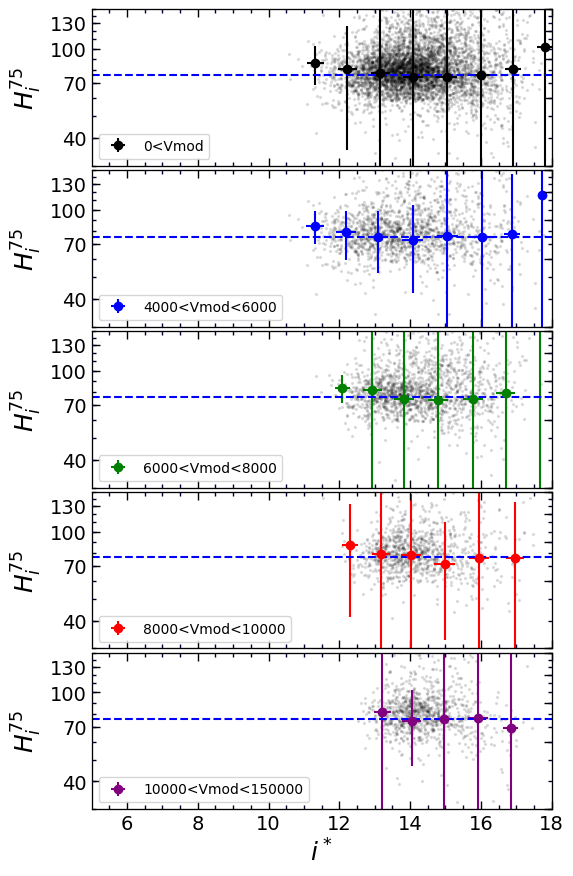

In [11]:
fig = py.figure(figsize=(5, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(5,1) ; p=0

mag='i'


ax = plt.subplot(gs[p]) ; p+=1
PlotMe(ax, df, 0, 20000, color='k', delta=0, label='0<Vmod', param='Vmod', mag=mag)

ax = plt.subplot(gs[p]) ; p+=1
PlotMe(ax, df, 4000, 6000, color='b', delta=0, label='4000<Vmod<6000', param='Vmod', mag=mag)

ax = plt.subplot(gs[p]) ; p+=1
PlotMe(ax, df, 6000, 8000, color='g', delta=0, label='6000<Vmod<8000', param='Vmod', mag=mag)

ax = plt.subplot(gs[p]) ; p+=1
PlotMe(ax, df, 8000, 10000, color='r', delta=0, label='8000<Vmod<10000', param='Vmod', mag=mag)

ax = plt.subplot(gs[p]) ; p+=1
PlotMe(ax, df, 10000, 15000, color='purple', delta=0, label='10000<Vmod<150000', param='Vmod', mag=mag)

ax.set_xlabel(r'$i^*$', fontsize=18)

plt.subplots_adjust(hspace=0.03, wspace=0.2)

In [12]:
# df = cf3[["DM"]].join(cf4[["Vmod", "DMi", "DMi_new","Sqlt", "iii", "logWimx"]][cf4.Sqlt>2], how='left').dropna()
# df["H0_new"], df["logH_new"] = MakeHUB(df.Vmod, df.DMi_new)
# df["H0"], df["logH"] = MakeHUB(df.Vmod, df.DMi)
# df["H0_3"], df["logH_3"] = MakeHUB(df.Vmod, df.DM)
# df.head()

[-0.59834683  3.41391709]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f44b75d74d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f44b76a8d90>)

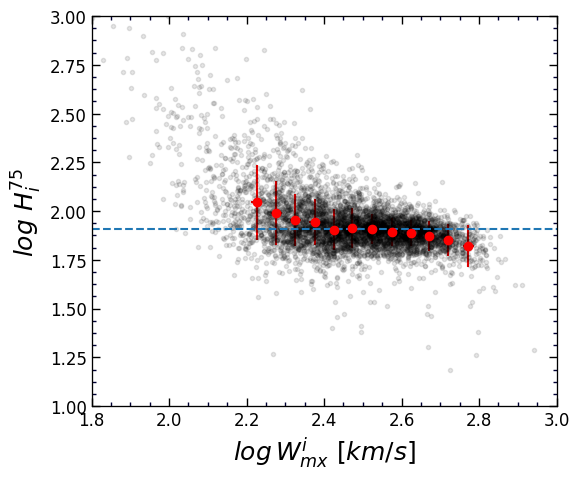

In [22]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = df.logWimx.values
Y = df.logH_new.values

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(2.2,2.8,0.05):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.05:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.mean(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     

        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/\/H^{75}_{i}$', fontsize=18)

v = np.linspace(1.8,3,50)

ax.plot(v,0*v+np.median(Y), '--')


print c

set_axes(ax, (1.8,3), (1,3), fontsize=12)